In [1]:
# Bibliotecas
import sys
sys.path.append('/home/jp/.snap/snap-python')
import snappy
from snappy import GPF
from snappy import ProductIO
from snappy import HashMap
from snappy import jpy
from snappy import ProductUtils
from snappy import WKTReader
import rasterio as rio
import matplotlib.pyplot as plt

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.


In [2]:
base_path = '/media/jp/FreeAgent GoFlex Drive/SAR/SLC_raw/AE04'
file_path = 'S1A_IW_SLC__1SDV_20220817T090719_20220817T090746_044590_055287_A29D.zip'
file = base_path + file_path

In [3]:
# Funçao para entender os parâmetros de cada operador
def op_info(operator):
  op = snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)
  print('Nome do operador: {} '.format(op.getOperatorDescriptor().getName()))
  print('Nome do operador na API: {} '.format(op.getOperatorDescriptor().getAlias()))
  param_desc = op.getOperatorDescriptor().getParameterDescriptors()
  for i in param_desc:
    print('{}: {}\nValor padrao: {}\n'.format(i.getName(), i.getDescription(), i.getDefaultValue()))

In [4]:
# Acessando os operadores Java
HashMap = jpy.get_type('java.util.HashMap')
parameters = HashMap()

# Função para ler arquivo
def read(file):
  return ProductIO.readProduct(file)

# Funçao para gravar arquivo
def write(product, file):
  ProductIO.writeProduct(product, file, "GeoTIFF")

In [5]:
op_info('Terrain-Correction')

Nome do operador: org.esa.s1tbx.sar.gpf.geometric.RangeDopplerGeocodingOp 
Nome do operador na API: Terrain-Correction 
sourceBandNames: The list of source bands.
Valor padrao: None

demName: The digital elevation model.
Valor padrao: SRTM 3Sec

externalDEMFile: None
Valor padrao: None

externalDEMNoDataValue: None
Valor padrao: 0

externalDEMApplyEGM: None
Valor padrao: true

demResamplingMethod: None
Valor padrao: BILINEAR_INTERPOLATION

imgResamplingMethod: None
Valor padrao: BILINEAR_INTERPOLATION

pixelSpacingInMeter: The pixel spacing in meters
Valor padrao: 0

pixelSpacingInDegree: The pixel spacing in degrees
Valor padrao: 0

mapProjection: The coordinate reference system in well known text format
Valor padrao: WGS84(DD)

alignToStandardGrid: Force the image grid to be aligned with a specific point
Valor padrao: false

standardGridOriginX: x-coordinate of the standard grid's origin point
Valor padrao: 0

standardGridOriginY: y-coordinate of the standard grid's origin point
Valo

In [4]:
# TOPSAR-Split
def split(product):
    parameters.put('subswath', 'IW2')
    parameters.put('selectedPolarisations', 'VH,VV')
    parameters.put('firstBurstIndex', '2')
    parameters.put('lastBurstIndex', '4')
    return GPF.createProduct("TOPSAR-Split", parameters, product)

In [5]:
# Orbit files
def apply_orbit_file(product):   
    parameters.put("Orbit State Vectors", "Sentinel Precise (Auto Download)")
    parameters.put("Polynomial Degree", 3) 
    parameters.put('continueOnFail', 'false')   
    return GPF.createProduct("Apply-Orbit-File", parameters, product)

In [6]:
# Calibration
def calibration(product):
    parameters.put('selectedPolarisations', 'VH,VV')
    parameters.put('outputImageInComplex', 'true')
    parameters.put('outputImageScaleInDb', 'false')

    return GPF.createProduct('Calibration', parameters, product)

In [7]:
# Deburst
def deburst(product):
    parameters.put("Polarisations", "VH, VV")
    return GPF.createProduct("TOPSAR-Deburst", parameters, product)

In [ ]:
op_info('TOPSAR-Deburst')

Nome do operador: org.esa.s1tbx.sentinel1.gpf.TOPSARDeburstOp 
Nome do operador na API: TOPSAR-Deburst 
selectedPolarisations: The list of polarisations
Valor padrao: None



In [8]:
# Matriz C2
def C2_matrix(product):
  parameters.put('matrix', 'C2')

  return GPF.createProduct('Polarimetric-Matrices', parameters, product)

In [9]:
# Speckle filter
def speckle_filter(product):
  return GPF.createProduct('Speckle-Filter', parameters, product)

In [10]:
# Terrain Correction
def terrain_correction(product):
  parameters.put('demName', 'Copernicus 30m Global DEM')
  parameters.put('demResamplingMethod', 'NEAREST_NEIGHBOUR')
  parameters.put('imgResamplingMethod', 'NEAREST_NEIGHBOUR')
  parameters.put('mapProjection', 'EPSG:32722')
  parameters.put('pixelSpacingInMeter', 14.78)
  parameters.put('outputComplex', 'true')
  return GPF.createProduct('Terrain-Correction', parameters, product)

In [11]:
# Multilooking
def multilooking(product):
  parameters.put('nRgLooks', 4)
  parameters.put('nAzLooks', 1)
  parameters.put('outputIntensity', 'true')
  parameters.put('grSquarePixel', 'true')
  return GPF.createProduct('Multilook', parameters, product )

In [12]:
# Linear to dB
def linear_to_db(product):
  #parameters.put('sourceBands', 'Intensity_IW2_VH, Intensity_IW2_VV')
  return GPF.createProduct('LinearToFromdB', parameters, product)

In [ ]:
def subset(product, wkt):
    geom = WKTReader().read(wkt)
    parameters.put('copyMetadata', True)
    parameters.put('geoRegion', geom)
    SAR_image_subset = GPF.createProduct('Subset', parameters, product)
    return SAR_image_subset

In [14]:
# Fluxo de processos
def workflow(file):

  print('read')
  product = read(file)

  print('TOPSAR-split')
  spt = split(product)

  print('Orbit file')
  orbit = apply_orbit_file(spt)

  print('Calibration')
  cal = calibration(orbit)

  print('Deburst')
  deb = deburst(cal)

  print('C2')
  C2 = C2_matrix(deb)
  write(C2, '/home/jp/Documents/IME/TCC/CODE/Capstone-Project/data/c2/area4_'+'C2.tif')

  # print('Speckle filter')
  spk = speckle_filter(deb)
  spk = deb

  print('Multilooking')
  mult = multilooking(spk)

  print('Terrain Correction')
  TC = terrain_correction(mult)

  print('to dB')
  dB = linear_to_db(TC)
  write(dB, '/media/jp/FreeAgent GoFlex Drive/SAR/SLC_raw/AE04/area4_split_orb_cal_deb_spk_mult_TC_dB.tif')


In [ ]:
wkt_dict = {
    'area4':
}

In [ ]:
# Fluxo de processos
def workflow_SLC(file, area_name):

  print('read')
  product = read(file)

  print('TOPSAR-split')
  spt = split(product)

  print('Orbit file')
  orbit = apply_orbit_file(spt)

  print('Calibration')
  cal = calibration(orbit)

  print('Deburst')
  deb = deburst(cal)

  print('Terrain Correction')
  TC = terrain_correction(deb)

  TC = subset(TC, wkt_dict.get(area_name))

  print('C2')
  C2 = C2_matrix(TC)
  write(C2, f'/home/jp/Documents/IME/TCC/CODE/Capstone-Project/data/c2/{area_name}_'+'C2.tif')

  # print('Speckle filter')
  spk = speckle_filter(TC)
  spk = deb

  print('Multilooking')
  mult = multilooking(spk)

  print('to dB')
  dB = linear_to_db(mult)
  write(dB, f'/media/jp/FreeAgent GoFlex Drive/SAR/SLC_raw/AE04/{area_name}_split_orb_cal_deb_spk_mult_TC_dB.tif')

In [19]:
# file = '/content/drive/MyDrive/PDISAR/Sentinel-1/S1A_IW_SLC__1SDV_20220311T084529_20220311T084556_042271_0509D6_F31D.zip'
file = '/home/jp/Downloads/~/Downloads/S1A_IW_SLC__1SDV_20220530T091547_20220530T091614_043438_052FDA_88B2.zip'

In [20]:
workflow(file)

read
TOPSAR-split
Orbit file

Calibration
100% done.

100% done.

100% done.
Deburst
C2

100% done.

100% done.

100% done.


SEVERE: org.esa.s1tbx.io.sentinel1.Sentinel1Level1Directory: S1A_IW_SLC__1SDV_20220530T091547_20220530T091614_043438_052FDA_88B2.SAFE/measurement/s1a-iw3-slc-vh-20220530t091547-20220530t091613-043438-052fda-003.tiff not found
SEVERE: org.esa.s1tbx.io.sentinel1.Sentinel1Level1Directory: S1A_IW_SLC__1SDV_20220530T091547_20220530T091614_043438_052FDA_88B2.SAFE/measurement/s1a-iw3-slc-vv-20220530t091547-20220530t091613-043438-052fda-006.tiff not found
SEVERE: org.esa.s1tbx.io.sentinel1.Sentinel1ProductReader: Unable to load quicklook S1A_IW_SLC__1SDV_20220530T091547_20220530T091614_043438_052FDA_88B2


Multilooking

Terrain Correction
to dB
100% done.

100% done.

100% done.
Copernicus_DSM_COG_10_S06_00_W055_00_DEM.tif
Copernicus_DSM_COG_10_S06_00_W054_00_DEM.tif
Copernicus_DSM_COG_10_S07_00_W055_00_DEM.tif
Copernicus_DSM_COG_10_S07_00_W054_00_DEM.tif


In [21]:
# Visualizando dado
with rio.open('/media/jp/FreeAgent GoFlex Drive/TCC/split_orb_cal_deb_spk_mult_TC_dB.tif') as src:
  VH = src.read(1)

In [10]:
c2[0]

TypeError: 'org.esa.snap.core.datamodel.Product' object is not subscriptable

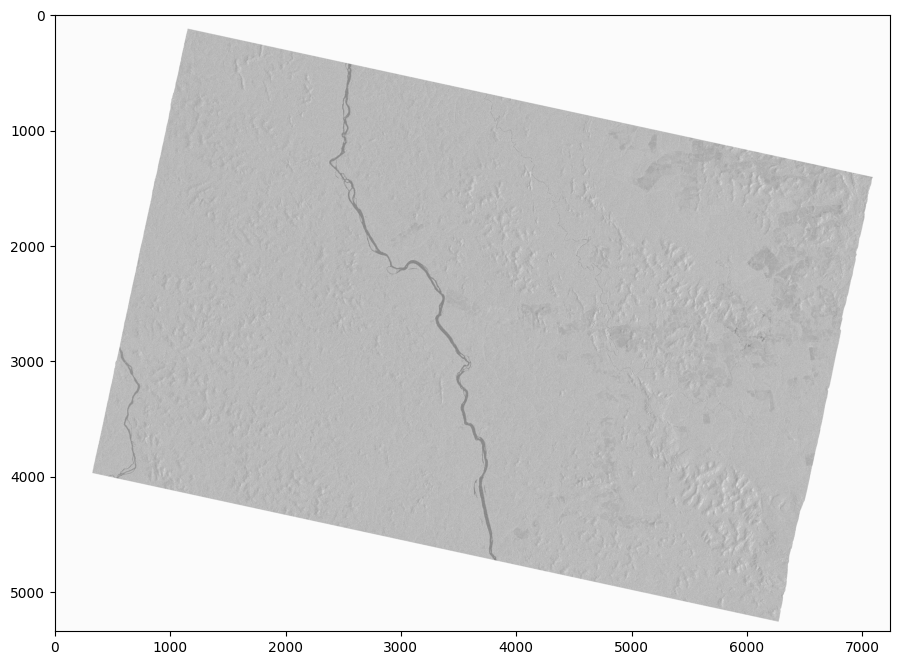

In [22]:
plt.figure(figsize=(12,8))
plt.imshow(VH, cmap = 'gray')

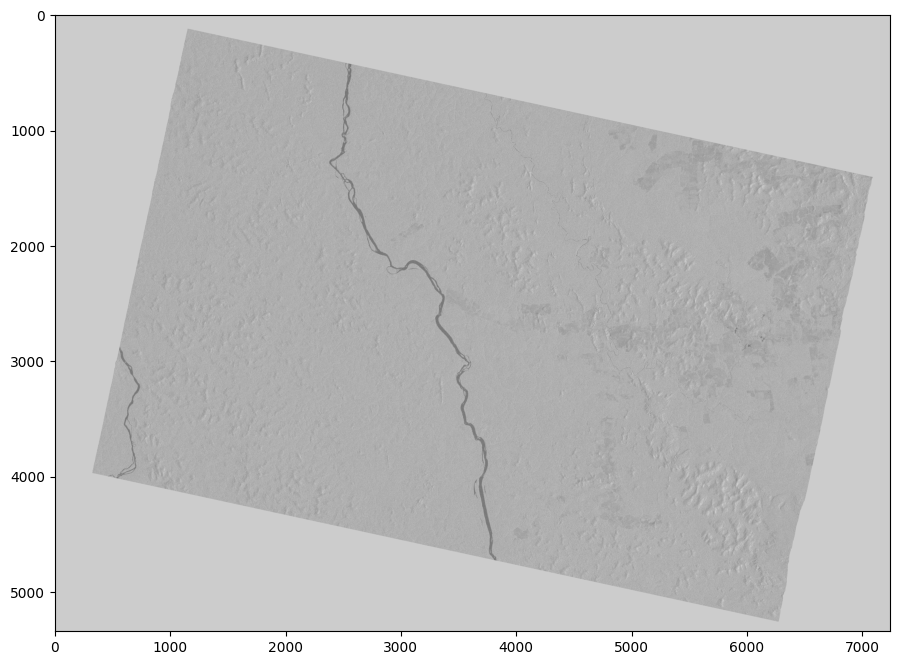

In [26]:
with rio.open('/media/jp/FreeAgent GoFlex Drive/TCC/split_orb_cal_deb_spk_mult_TC_dB.tif') as src:
  VV = src.read(2)
plt.figure(figsize=(12,8))
plt.imshow(VV, cmap = 'gray')

In [ ]:
!mv /content/split_orb_cal_deb_spk_mult_TC_dB.tif /content/drive/MyDrive/PDISAR/Sentinel-1

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
!mv /content/C2.tif /content/drive/MyDrive/PDISAR/Sentinel-1

/bin/bash: /usr/local/lib/libtinfo.so.6: no version information available (required by /bin/bash)
